# CNN Model Evaluation
This notebook demonstrates the comprehensive evaluation features of the CNN model for spam detection.

In [2]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from models.cnn import SpamCNN
from utils.functions import encode, load_glove_embeddings, build_vocab
import pandas as pd

In [3]:
ROOT_PATH = './'
DATA_PATH = os.path.abspath(os.path.join(ROOT_PATH, '../spam-detection-data/'))
DATA_PATH

'/home/michael/PycharmProjects/spam-detection-data'

In [4]:
GLOVE_PATH = os.path.join(DATA_PATH, 'data/raw/glove.6B/glove.6B.300d.txt')
GLOVE_PATH

'/home/michael/PycharmProjects/spam-detection-data/data/raw/glove.6B/glove.6B.300d.txt'

In [5]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')

In [6]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
# torch.cuda.empty_cache()  # Clear any existing allocations
device

'cpu'

In [8]:
# Build vocabulary and load embeddings
set_seed(42)
word2idx, idx2word = build_vocab(train_df['text'])
embedding_dim = 300
max_len = 200

In [9]:
pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word2idx, embedding_dim)

In [10]:
# Load the trained CNN model
model_path = DATA_PATH + '/trained_models/spam_cnn.pt'
cnn_model = SpamCNN(vocab_size=len(word2idx), embedding_dim=embedding_dim, 
                    pretrained_embeddings=pretrained_embeddings)
cnn_model.load(model_path, map_location=device)  # map_location handled in load()
cnn_model = cnn_model
cnn_model.eval()

SpamCNN(
  (embedding): Embedding(25373, 300)
  (conv1): Conv1d(300, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(64, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [10]:
# After loading the model and moving it to device
# print("Testing minimal backward pass...")
# try:
#     # Use valid indices for the embedding layer
#     vocab_size = len(word2idx)
#     dummy_input = torch.randint(0, vocab_size, (1, 200), dtype=torch.long, device=device)
#     dummy_output = cnn_model(dummy_input)
#     dummy_output.sum().backward()
#     print("Minimal backward pass test successful.")
#     cnn_model.zero_grad() # Clear gradients
# except RuntimeError as e:
#     print(f"Minimal backward pass test failed with error: {e}")

In [11]:
# Prepare test data
X_test_tensor = torch.tensor([encode(t, word2idx, max_len) for t in test_df['text']])
y_test_tensor = torch.tensor(test_df['label'].values, dtype=torch.float32)

# Move data to device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

## 1. Comprehensive Performance Metrics

In [12]:
from utils.cnn_evaluation import compute_metrics

# Get model predictions
with torch.no_grad():
    y_pred_probs = cnn_model(X_test_tensor)
    y_pred = (y_pred_probs > 0.5).float()

# Compute comprehensive metrics
print("Computing comprehensive metrics...")
metrics = compute_metrics(y_test_tensor, y_pred, y_pred_probs)

print("\nModel Performance Metrics:")
print(f"False Positive Rate: {metrics['fpr']:.4f}")
print(f"False Negative Rate: {metrics['fnr']:.4f}")
print(f"AUC-ROC: {metrics['auc_roc']:.4f}")
print(f"Weighted Error (FP=0.3, FN=0.7): {metrics['weighted_error']:.4f}")
print(f"Accuracy {metrics['accuracy']:.4f}")
print(f"Precision {metrics['precision']:.4f}")
print(f"Recall {metrics['recall']:.4f}")
print(f"F1 Score {metrics['f1_score']:.4f}")
print(f"Specificity {metrics['specificity']:.4f}")

Computing comprehensive metrics...

Model Performance Metrics:
False Positive Rate: 0.3488
False Negative Rate: 0.6512
AUC-ROC: 0.9894
Weighted Error (FP=0.3, FN=0.7): 260.0711
Accuracy 0.5562
Precision 0.3140
Recall 0.3488
F1 Score 0.3305
Specificity 0.6512


## 2. Explainability Analysis

In [13]:
# Generate Grad-CAM explanations
# NOTE: Do NOT use torch.no_grad() here, as Grad-CAM needs gradients!
print("\nGenerating explanations...")
cam_maps = cnn_model.grad_cam(X_test_tensor)

# Compute explainability metrics
exp_metrics = cnn_model.compute_explanation_metrics(X_test_tensor, cam_maps)

print("\nExplanation Quality Metrics:")
print(f"AUC-Del (Faithfulness): {exp_metrics['auc_del']:.4f}")
print(f"AUC-Ins (Comprehensiveness): {exp_metrics['auc_ins']:.4f}")
print(f"Stability Score: {exp_metrics['stability']:.4f}")
print(f"Explanation Consistency Score: {exp_metrics['ecs']:.4f}")


Generating explanations...


/home/michael/PycharmProjects/spam_detection2/venv/lib/python3.10/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Explanation Quality Metrics:
AUC-Del (Faithfulness): 0.2442
AUC-Ins (Comprehensiveness): 0.7367
Stability Score: 0.4462
Explanation Consistency Score: 0.5613



Visualizing explanations for sample emails...


/tmp/ipykernel_374773/695318155.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


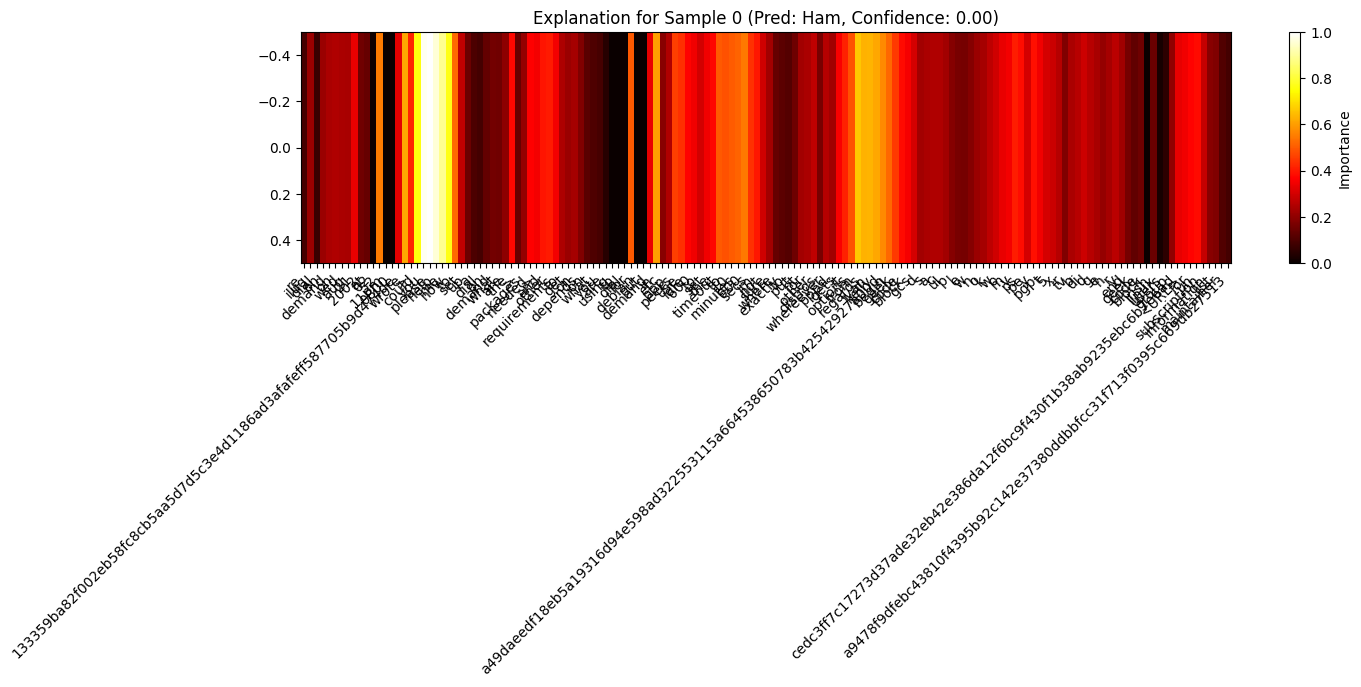

/tmp/ipykernel_374773/695318155.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


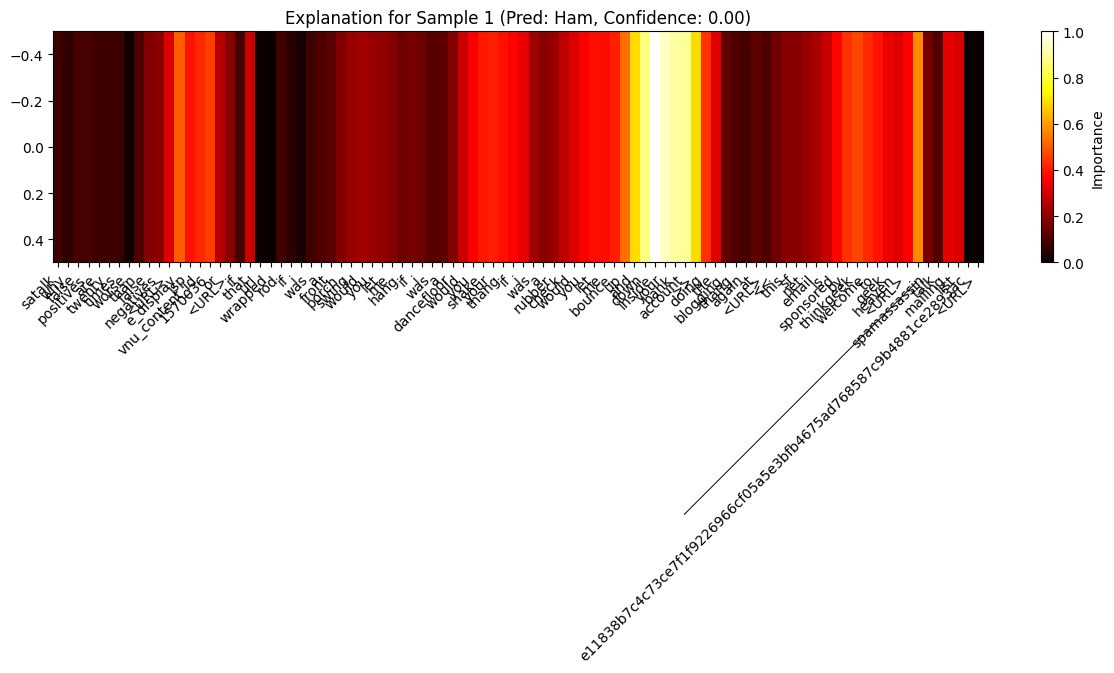

/tmp/ipykernel_374773/695318155.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


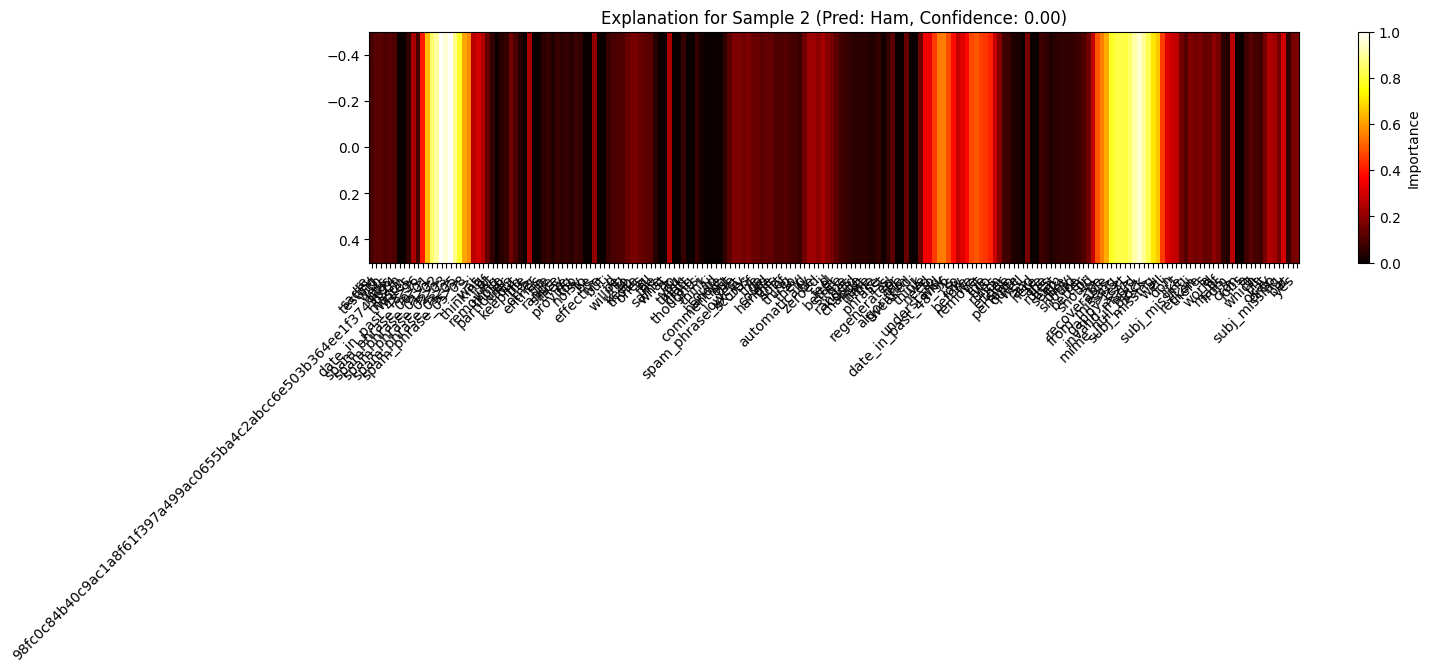

In [14]:
def visualize_explanation(text, cam_map, pred_prob, idx):
    # Tokenize text
    tokens = text.split()[:max_len]  # Truncate to max_len
    
    # Create heatmap
    plt.figure(figsize=(15, 3))
    plt.imshow(cam_map[:len(tokens)].cpu().numpy().reshape(1, -1), 
               aspect='auto', cmap='hot')
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
    plt.colorbar(label='Importance')
    plt.title(f'Explanation for Sample {idx} (Pred: {"Spam" if pred_prob > 0.5 else "Ham"}, '
              f'Confidence: {pred_prob:.2f})')
    plt.tight_layout()
    plt.show()

# Visualize a few examples
print("\nVisualizing explanations for sample emails...")
for i in range(3):  # Show first 3 examples
    visualize_explanation(
        test_df['text'].iloc[i], 
        cam_maps[i], 
        y_pred_probs[i].item(),
        i
    )

## 3. Adversarial Robustness Analysis

In [15]:
# Test adversarial robustness
print("\nTesting adversarial robustness...")
# Use a smaller batch for demonstration
test_batch_size = 32
X_test_batch = X_test_tensor[:test_batch_size]
y_test_batch = y_test_tensor[:test_batch_size]

# Measure robustness across different perturbation levels
robustness_metrics = cnn_model.measure_adversarial_robustness(
    X_test_batch, 
    y_test_batch,
    epsilon_range=[0.01, 0.05, 0.1]
)

print("\nAdversarial Robustness Results:")
print(f"Clean Accuracy: {robustness_metrics['clean_accuracy']:.4f}")

print("\nAccuracy under different perturbation sizes:")
for epsilon, acc in robustness_metrics['adversarial_accuracy'].items():
    print(f"ε={epsilon}: {acc:.4f}")

print("\nExplanation shift under different perturbation sizes:")
for epsilon, shift in robustness_metrics['explanation_shift'].items():
    print(f"ε={epsilon}: {shift:.4f}")


Testing adversarial robustness...

Adversarial Robustness Results:
Clean Accuracy: 0.6250

Accuracy under different perturbation sizes:
ε=0.01: 0.6250
ε=0.05: 0.6250
ε=0.1: 0.6250

Explanation shift under different perturbation sizes:
ε=0.01: 0.0000
ε=0.05: 0.0000
ε=0.1: 0.0000


In [16]:
# Comprehensive adversarial evaluation
print("\nComprehensive adversarial evaluation...")
adv_evaluation = cnn_model.evaluate_adversarial_examples(X_test_batch, y_test_batch)

print("\nClean vs Adversarial Performance:")
print("Clean Performance:")
print(f"- Accuracy: {1 - adv_evaluation['clean']['performance']['weighted_error']:.4f}")
print(f"- ECS: {adv_evaluation['clean']['explanations']['ecs']:.4f}")

print("\nAdversarial Performance:")
print(f"- Accuracy: {1 - adv_evaluation['adversarial']['performance']['weighted_error']:.4f}")
print(f"- ECS: {adv_evaluation['adversarial']['explanations']['ecs']:.4f}")



Comprehensive adversarial evaluation...

Clean vs Adversarial Performance:
Clean Performance:
- Accuracy: -5.0000
- ECS: 0.6011

Adversarial Performance:
- Accuracy: -5.0000
- ECS: 0.5910
